In [1]:
%pylab inline
import matplotlib.dates as mdates
import datetime
import tqdm
import pandas as pd
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters, deregister_matplotlib_converters
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


# Reading data & doing stuff

In [2]:
data = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')

In [3]:
deregister_matplotlib_converters()

In [4]:
nation = 'RU'
additional_points = np.asarray([134687], dtype=np.int)
min_val = 100
natl_data = data[data.geoId == nation].sort_values(['year', 'month', 'day'])
natl_data.cases.sum()

124054

In [5]:
cases = np.cumsum(natl_data.cases)
first_day = datetime.datetime.strptime(natl_data[cases >= min_val].iloc[0].dateRep, '%d/%m/%Y')
real_cases = np.concatenate([cases[cases >= min_val].values, additional_points[additional_points > cases.iloc[-1]]])
cases = real_cases[:]

In [6]:
first_day.strftime('%-e %b %Y')

'18 Mar 2020'

In [7]:
def get_dates(a, b=None):
    if b is None:
        a,b = 0,a
    if type(b) is not int:
        b = len(b)
    return mdates.date2num(first_day) + np.arange(a, a + b)

In [8]:
real_cases

array([   114,    147,    199,    253,    306,    438,    438,    495,
          658,    840,   1036,   1264,   1534,   1836,   2337,   2777,
         3548,   4149,   4731,   5389,   6343,   7497,   8672,  10131,
        11917,  13584,  15770,  18328,  21102,  24490,  27938,  32008,
        36793,  42853,  47121,  52763,  57999,  62773,  68622,  74588,
        80949,  87147,  93558,  99399, 106498, 114431, 124054, 134687])

In [9]:
len(cases)

48

# Some basic plots

In [10]:
def plot_dates(dates, array=None, **kwargs):
    kwargs.setdefault('marker', '.')
    kwargs.setdefault('ls', '-')
    if array is None:
        array = dates
        dates = get_dates(array)
    plt.plot_date(dates, array, **kwargs)

In [11]:
dates_cases = get_dates(cases)

In [12]:
def set_plot(*args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    plt.grid()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.num2date(dates_cases[-1]).weekday()))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    return fig, ax

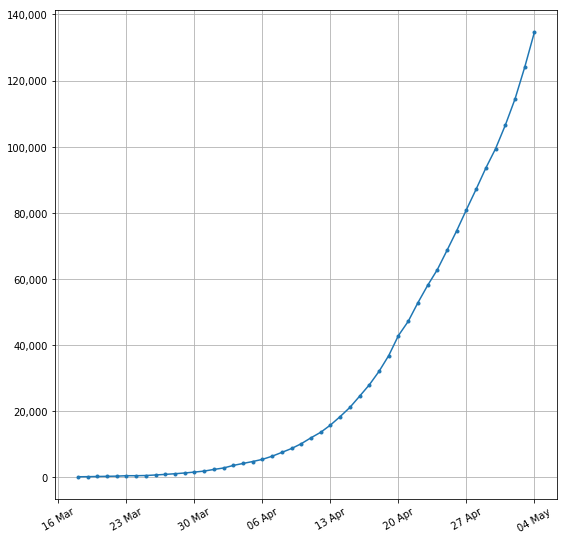

In [13]:
fig, ax = set_plot(figsize=(9,9))
plt.plot_date(dates_cases, cases, ls='-', marker='.')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
#plot_dates((2**(1./3.))**np.arange(len(cases)) * 6.5, marker='None')

In [14]:
len(cases)

48

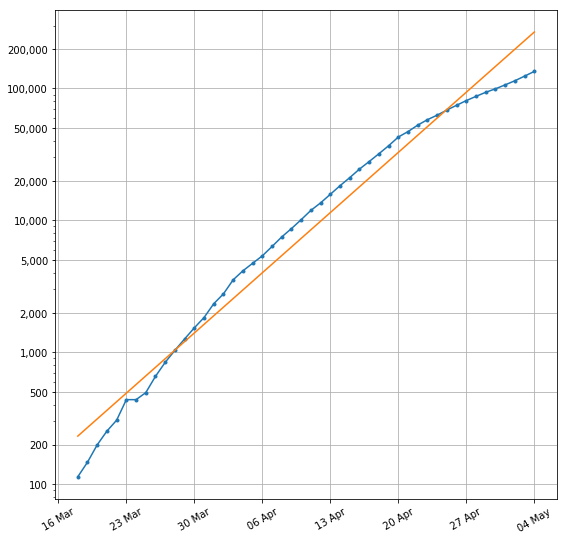

In [15]:
fig, ax = set_plot(figsize=(9,9))
plt.yscale('log')
plt.plot_date(dates_cases, cases, ls='-', marker='.')
lr_cases = LinearRegression().fit(dates_cases.reshape(-1,1), np.log(cases))
ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(subs=[1., 2., 5.]))
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.plot_date(dates_cases, np.exp(lr_cases.predict(dates_cases.reshape(-1,1))), ls='-', marker='None')

In [16]:
first_day.weekday()

2

In [17]:
log_cases = np.log(cases)

In [18]:
log_growth = log_cases[1:] - log_cases[:-1]

# Are we exponential?

decline in case growth rate, statistically significant


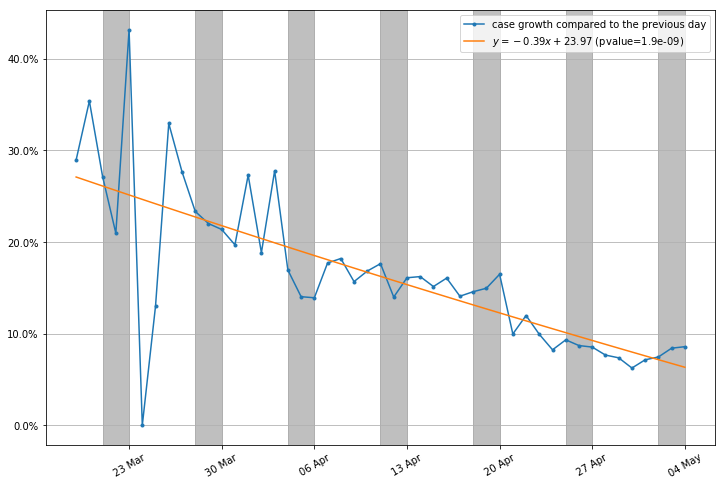

In [19]:
fig, ax = set_plot(figsize=(12,8))
plt.plot_date(dates_cases[1:], (np.exp(log_growth)-1), ls='-', marker='.', label='case growth compared to the previous day')
lr_growth = stats.linregress(dates_cases[1:], log_growth)
lr_trend = np.exp(dates_cases[1:] * lr_growth.slope + lr_growth.intercept) - 1
lr_label = '$y={:.2f}x + {:.2f}$ (pvalue={:.2g})'.format(
    lr_growth.slope * 100, (lr_growth.intercept + lr_growth.slope * dates_cases[1]) * 100, lr_growth.pvalue)
plt.plot_date(dates_cases[1:], lr_trend, ls='-', marker='None', label=lr_label)
first_unpainted_date = 0
for i in dates_cases[1:]:
    wday = mdates.num2date(i).weekday()
    if wday >= 5 and i >= first_unpainted_date:
        first_unpainted_date = min(dates_cases[-1], i + (7 - wday))
        if i != first_unpainted_date:
            plt.axvspan(i, first_unpainted_date, color='gray', alpha=.5)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.linspace(0, 1, 11)))
verdict = '{} in case growth rate, statistically {}'.format(('decline' if lr_growth.slope < 0 else 'increase'), 
                                                           ('significant' if lr_growth.pvalue < 0.05 else 'insignificant'))
plt.legend()
print(verdict)

In [20]:
lr_growth.rvalue ** 2

0.554790871398575

# Let's try to make predictions for the future

In [21]:
log_growths_adjusted = log_growth - (dates_cases[1:] * lr_growth.slope + lr_growth.intercept)

In [22]:
def simulate(n_sims, n_days, linear=False, zero_cap=False):
    cur = log_cases[-1]
    if linear:
        growths = log_growths_adjusted[np.random.randint(0, len(log_growth), size=(n_sims, n_days))]
        dates = get_dates(len(cases) + n_days)
        trend = dates[len(cases):] * lr_growth.slope + lr_growth.intercept
        growths += trend
    else:
        growths = log_growth[np.random.randint(0, len(log_growth), size=(n_sims, n_days))]
    if zero_cap:
        growths = np.maximum(growths, 0)
    res = cur + np.cumsum(growths, axis=1)
    return np.exp(res)

In [23]:
%%time
n_sims = 10**6
n_days = 7 * 3
results = simulate(n_sims, n_days, linear=True, zero_cap=True)    

CPU times: user 732 ms, sys: 308 ms, total: 1.04 s
Wall time: 1.1 s


growth rates are not normally distributed (0.0000)


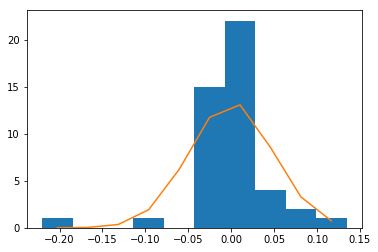

In [24]:
_, pv_shapiro = stats.shapiro(log_growths_adjusted)
if pv_shapiro < 0.05:
    print('growth rates are not normally distributed ({:.4f})'.format(pv_shapiro))
else:
    print('growth rates may be normally distributed ({:.4f})'.format(pv_shapiro))

counts, buckets, *patches = plt.hist(log_growths_adjusted[1:])
cdf = stats.norm.cdf(buckets, loc=(np.mean(log_growths_adjusted[1:])), scale=np.std(log_growths_adjusted[1:])) * len(log_growths_adjusted[1:])
plt.plot((buckets[1:] + buckets[:-1]) * .5, cdf[1:] - cdf[:-1])

In [25]:
%%time
p5, p50, p95 = np.percentile(results, q=[5,50,95], axis=0)

CPU times: user 813 ms, sys: 82.6 ms, total: 896 ms
Wall time: 908 ms


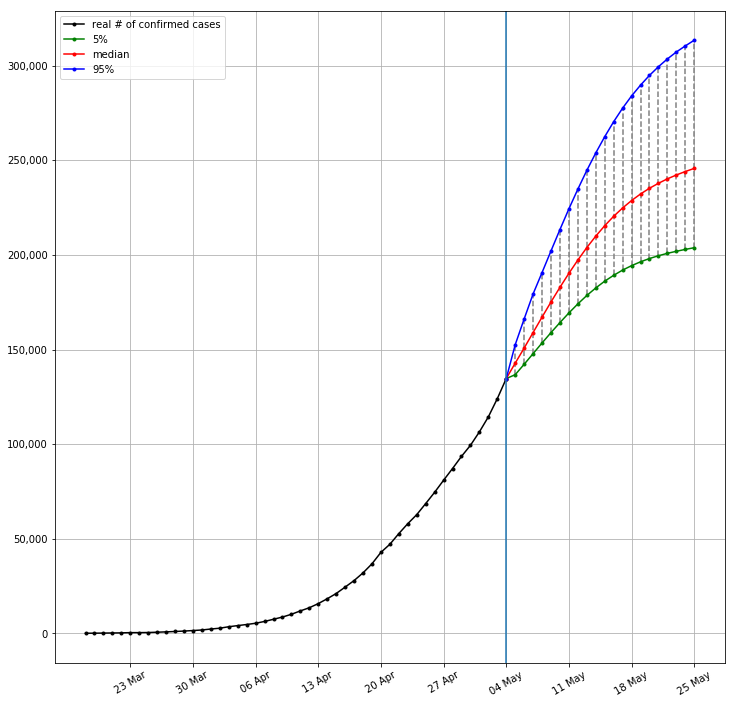

In [26]:
fig, ax = set_plot(figsize=(12,12))
plot_days = 7 * 3
dates = get_dates(len(cases) + plot_days)
plot_dates(real_cases, color='black', label='real # of confirmed cases')
plot_dates(dates[len(cases)-1:], np.concatenate([[cases[-1]], p5[:plot_days]]), color='green', label='5%')
plot_dates(dates[len(cases)-1:], np.concatenate([[cases[-1]], p50[:plot_days]]), color='red', label='median')
plot_dates(dates[len(cases)-1:], np.concatenate([[cases[-1]], p95[:plot_days]]), color='blue', label='95%')
plt.vlines(dates[len(cases):], p5, p95, colors='gray', linestyles='dashed')
plt.legend()
ax.xaxis.set_ticks(dates[(len(cases) - 1) % 7::7])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.axvline(dates[len(cases) - 1])
name = 'covid-{}-{}.'.format(nation, mdates.num2date(dates_cases[-1]).strftime('%d-%m'))
plt.savefig(name + 'svg')
plt.savefig(name + 'png')

In [27]:
%%time
results_gr = results - np.concatenate([np.repeat(cases[-1], n_sims)[:,np.newaxis], results[:,:-1]], axis=1)
p5_gr, p50_gr, p95_gr = np.percentile(results_gr, q=[5, 50, 95], axis=0)

CPU times: user 828 ms, sys: 169 ms, total: 997 ms
Wall time: 1.08 s


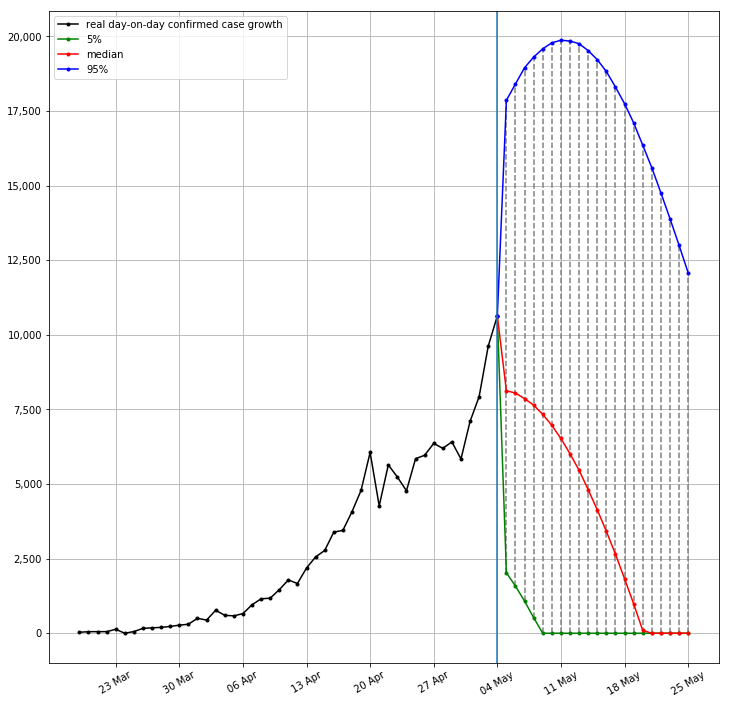

In [28]:
fig, ax = set_plot(figsize=(12,12))
plot_days = 7 * 3
dates = get_dates(len(cases) + plot_days)
real_cases_gr = real_cases[1:] - real_cases[:-1]
cases_gr = cases[1:] - cases[:-1]
plot_dates(dates[1:len(real_cases)], real_cases_gr, color='black', label='real day-on-day confirmed case growth')
plot_dates(dates[len(cases)-1:], np.concatenate([[cases_gr[-1]], p5_gr[:plot_days]]), color='green', label='5%')
plot_dates(dates[len(cases)-1:], np.concatenate([[cases_gr[-1]], p50_gr[:plot_days]]), color='red', label='median')
plot_dates(dates[len(cases)-1:], np.concatenate([[cases_gr[-1]], p95_gr[:plot_days]]), color='blue', label='95%')
plt.vlines(dates[len(cases):], p5_gr, p95_gr, colors='gray', linestyles='dashed')
plt.legend()
ax.xaxis.set_ticks(dates[(len(cases) - 1) % 7::7])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.axvline(dates[len(cases) - 1])
name = 'covid_gr-{}-{}.'.format(nation, mdates.num2date(dates_cases[-1]).strftime('%d-%m'))
plt.savefig(name + 'svg')
plt.savefig(name + 'png')

In [29]:
print('prediction for tomorrow:', round(np.median(results[:,0]), 1))
print('growth tomorrow:', round(np.median(results_gr[:,0]), 1))

prediction for tomorrow: 142812.1
growth tomorrow: 8125.1


In [30]:
is_peak = np.max(results_gr, axis=1) < np.max(cases_gr)
print('crude estimate of the probability of peak is {:.2f}%'.format(np.mean(is_peak) * 100))

crude estimate of the probability of peak is 6.00%


In [31]:
print(p5[0], p50[0], p95[0])
print(p5[1], p50[1], p95[1])
print(p5[2], p50[2], p95[2])
print(p5[3], p50[3], p95[3])

136717.0251815787 142812.06484396552 152548.79412938398
142222.1110711296 150789.87891016415 166171.5155186545
147855.26538544006 159006.88874382668 179402.55418452396
153490.74018506362 167157.34596178518 190699.58084305006
